# HOMEWORK 13

In this homework you are going to build your first classifier for the CIFAR-10 dataset. This dataset contains 10 different classes and you can learn more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html). This homework consists of the following tasks:
* Dataset inspection
* Building the network
* Training
* Evaluation

At the end, as usual, there will be a couple of questions for you to answer :-)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

2022-12-06 23:48:25.228825: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### Step 0: Dataset Inspection

Load the dataset and make a quick inspection.

170500096/170498071 [==============================] - 3s 0us/step
50000
[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


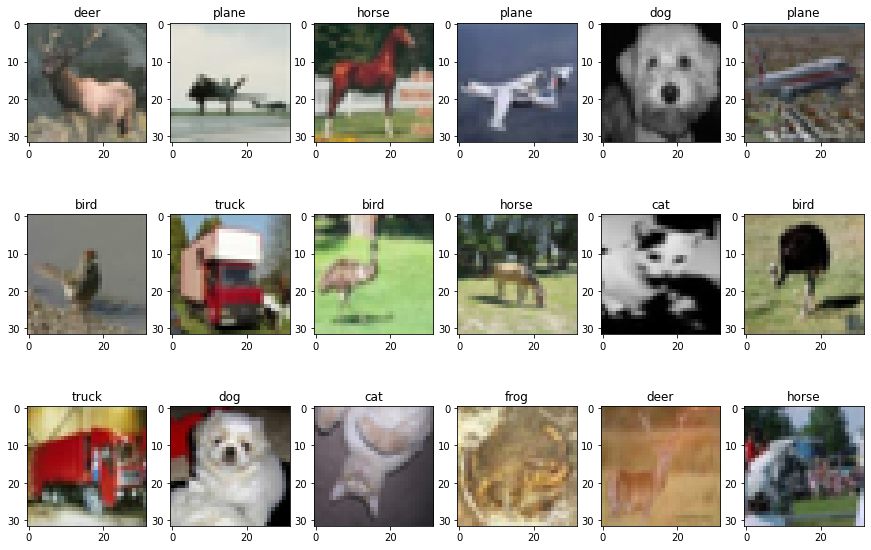

In [3]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Mapping from class ID to class name
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer',
           5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# Dataset params
num_classes = len(classes)
size = x_train.shape[1]
num_pictures = len(x_train)
print(num_pictures)
print(y_train)
# Visualize random samples (as a plot with 3x6 samples)
for ii in range(18):    
    plt.subplot(3,6,ii+1)
    # Pick a random sample
    idx = np.random.randint(1,num_pictures)
    # Show the image and the label
    plt.imshow(x_train[idx, ...])
    plt.title(classes[int(y_train[idx])])

Compute the class histogram (you can visualize it if you want). Is the dataset balanced?

Hint: You might find [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) tool useful. In any case, it's up to you how you compute the histogram.

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


(Text(0.5, 0, 'Class'), Text(0, 0.5, 'Counts'))

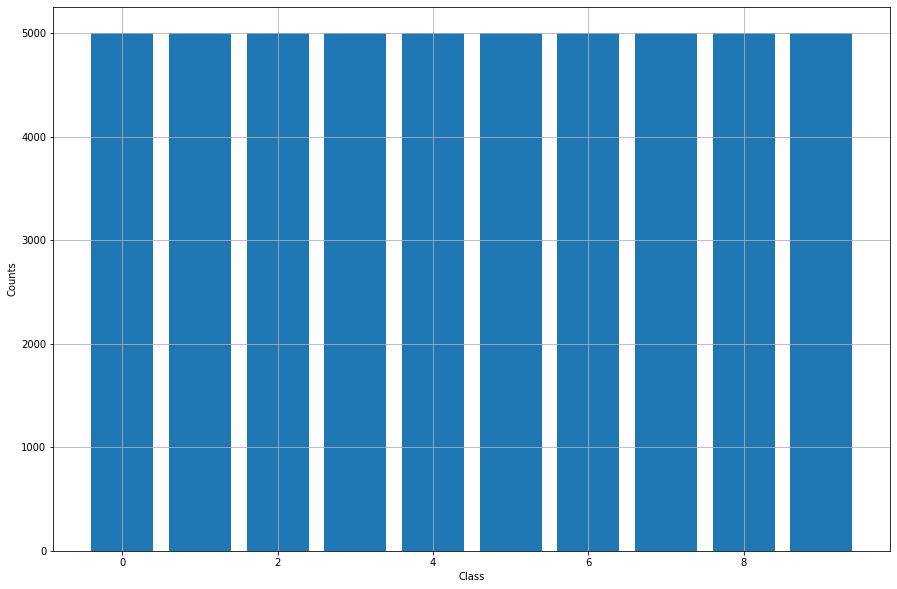

In [4]:
# Compute the class histogram
import pandas as pd


df = pd.DataFrame (y_train);

ids = df.iloc[:]

from collections import Counter
hist = Counter(df[0])


print(hist)
plt.bar(hist.keys(), hist.values()), plt.grid(True)
plt.xlabel('Class'), plt.ylabel('Counts')


### Step 1: Data Preparation

In this step, you'll need to prepare the data for training, i.e., you will have to normalize it and encode the labels as one-hot vectors.

In [5]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

# Normalization
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)


# Spiltting training and validation sets

x_val = x_train[:10000]
y_val = y_train[:10000]

x_train = x_train[10000:]
y_train = y_train[10000:]


Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)


In [6]:
print(x_train[0][0])

[[0.13725491 0.09803922 0.10196079]
 [0.10588235 0.08235294 0.08235294]
 [0.09803922 0.07843138 0.07450981]
 [0.10196079 0.07058824 0.07058824]
 [0.09411765 0.05882353 0.05882353]
 [0.08627451 0.05098039 0.05490196]
 [0.09019608 0.05490196 0.05490196]
 [0.09803922 0.06666667 0.05882353]
 [0.09803922 0.06666667 0.05882353]
 [0.09411765 0.0627451  0.05490196]
 [0.10196079 0.06666667 0.05882353]
 [0.09803922 0.06666667 0.05098039]
 [0.30980393 0.28235295 0.25490198]
 [0.4509804  0.42745098 0.38431373]
 [0.44313726 0.41960785 0.3764706 ]
 [0.45490196 0.43137255 0.40392157]
 [0.45882353 0.43137255 0.40784314]
 [0.4627451  0.43529412 0.4117647 ]
 [0.49019608 0.45882353 0.44313726]
 [0.50980395 0.47843137 0.47058824]
 [0.44705883 0.41568628 0.39607844]
 [0.42745098 0.4        0.36862746]
 [0.4745098  0.4509804  0.42352942]
 [0.47843137 0.46666667 0.47058824]
 [0.5411765  0.5294118  0.53333336]
 [0.49411765 0.48235294 0.4862745 ]
 [0.5411765  0.5411765  0.5529412 ]
 [0.5568628  0.5411765  0.54

### Step 2: Building the Classifier

Build the CNN for CIFAR10 classification. For starters, you can use the same network we used in the lesson for the MNIST problem.

In [7]:
inputs = Input(shape=(size, size, 3))


#net = Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:])

net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(inputs)



net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Flatten()(net)
outputs = Dense(10, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

2022-12-06 23:48:38.120518: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-06 23:48:38.124215: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-06 23:48:38.231432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 23:48:38.232283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-12-06 23:48:38.232435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-0

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490 

### Step 3: Training

Compile the model and train it.

In [8]:
epochs = 25
batch_size = 128

# Compile the model

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
# Train the model
#history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)


print('Elapsed time', time() - start)

2022-12-06 23:48:41.973396: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-06 23:48:41.986826: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000150000 Hz


Epoch 1/25


2022-12-06 23:48:42.630696: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-12-06 23:48:44.014703: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-12-06 23:48:44.040806: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


313/313 [==============================] - 12s 9ms/step - loss: 1.8873 - accuracy: 0.3189 - val_loss: 1.4109 - val_accuracy: 0.4983
Epoch 2/25
313/313 [==============================] - 2s 6ms/step - loss: 1.3797 - accuracy: 0.5149 - val_loss: 1.2751 - val_accuracy: 0.5528
Epoch 3/25
313/313 [==============================] - 2s 6ms/step - loss: 1.2330 - accuracy: 0.5692 - val_loss: 1.1778 - val_accuracy: 0.5870
Epoch 4/25
313/313 [==============================] - 2s 7ms/step - loss: 1.1336 - accuracy: 0.6071 - val_loss: 1.1071 - val_accuracy: 0.6108
Epoch 5/25
313/313 [==============================] - 2s 6ms/step - loss: 1.0692 - accuracy: 0.6292 - val_loss: 1.0865 - val_accuracy: 0.6274
Epoch 6/25
313/313 [==============================] - 2s 6ms/step - loss: 1.0279 - accuracy: 0.6464 - val_loss: 1.0567 - val_accuracy: 0.6328
Epoch 7/25
313/313 [==============================] - 2s 6ms/step - loss: 0.9887 - accuracy: 0.6598 - val_loss: 0.9987 - val_accuracy: 0.6544
Epoch 8/25
313/3

Train Acc      0.7628499865531921
Validation Acc 0.6869000196456909


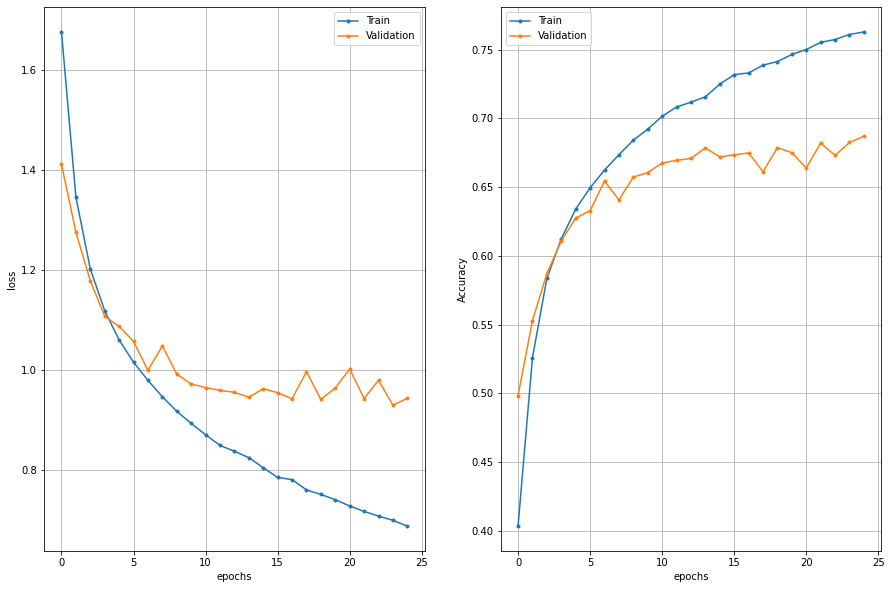

In [9]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])    

### Step 4: Evaluation

In this step, you have to calculate the accuracies and visualize some random samples. For the evaluation, you are going to use the test split from the dataset.

In [10]:
# Compute the labels and the predictions as sparse values
#y_true = 
#y_pred =

y_true = np.argmax(y_test, axis=1)
y_pred = model.predict(x_test)

print('True', y_true[0:5])
print('Pred', np.argmax(y_pred[0:5, :], axis=1))
print('Pred', y_pred[0:5, :])
print(y_pred.shape)

True [3 8 8 0 6]
Pred [3 8 8 0 4]
Pred [[5.9472513e-05 6.4880522e-05 9.9421246e-04 9.4644821e-01 1.4229782e-04
  4.5925431e-02 8.2524033e-04 1.8639451e-04 5.2204588e-03 1.3344448e-04]
 [2.7636227e-03 2.2915533e-02 7.8009663e-07 2.0100940e-08 4.0646235e-08
  3.1828458e-09 4.5633111e-10 1.7081707e-09 9.7423244e-01 8.7589440e-05]
 [3.2990763e-01 9.4964273e-02 1.2947429e-02 1.3319561e-02 7.9114912e-03
  9.2675711e-04 4.0423707e-05 1.5647396e-02 4.3447173e-01 8.9863293e-02]
 [9.1446263e-01 4.3392509e-02 1.9628039e-02 4.0732648e-05 2.3384802e-03
  6.7285271e-08 1.9978936e-06 8.1930790e-05 1.9835204e-02 2.1838167e-04]
 [1.0507459e-06 7.9753707e-05 5.8362111e-03 4.8375908e-02 8.1650782e-01
  9.6718373e-04 1.2803857e-01 7.4199202e-06 1.1247601e-04 7.3499752e-05]]
(10000, 10)


In [11]:
ev = model.evaluate(x_test, y_test)

print('Test loss  ', ev[0])
print('Test metric', ev[1])

y_pred = np.argmax(y_pred, axis =1)

313/313 [==============================] - 1s 3ms/step - loss: 0.9429 - accuracy: 0.6869
Test loss   0.9428987503051758
Test metric 0.6869000196456909


In [12]:
# Compute and print the accuracy for each class

for class_id, class_name in classes.items():
#for digit in digits:

        mask = y_true == class_id
        tp= np.sum(y_pred[mask] == class_id)
        total = np.sum(mask)
        print(class_id, ' ', tp/total)
        # class_total = y_true[i, :].sum()
        #class_correct = y_pred[i, i]   


    #acc = 100 * float(correct_count) / total_pred[class_id]
    #print(class_name, acc)
print('y_true', y_true[mask]) 
print('y_pred', y_pred[mask])    

0   0.797
1   0.841
2   0.596
3   0.555
4   0.679
5   0.468
6   0.705
7   0.712
8   0.749
9   0.767
y_true [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9

In [13]:
# Print the overall stats
ev = model.evaluate(x_test, y_test)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.9429 - accuracy: 0.6869
Test loss   0.9428987503051758
Test metric 0.6869000196456909


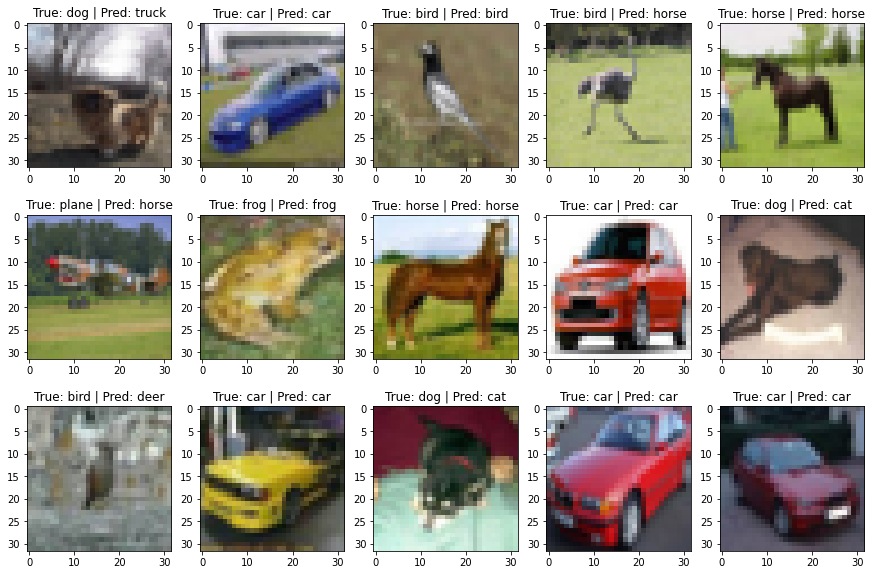

In [14]:
# Show random samples
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(0,len(y_pred))
    # Show the results
    plt.subplot(3,5,ii+1), plt.imshow(x_test[idx, ...])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred[idx]]))

### Questions
* What is the overall accuracy of the classifier?

Train Acc      0.7613999843597412
Validation Acc 0.6934999823570251


* What modifications would you do in order to improve the classification accuracy?

Let's add one more Convolution layer and run again
Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(net)
* Make **one** modification (that you think can help) and train the classifier again. Does the accuracy improve?


In [15]:
inputs = Input(shape=(size, size, 3))


#net = Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:])

net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(inputs)



net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(net)
net = Flatten()(net)
outputs = Dense(10, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0   

In [16]:
epochs = 25
batch_size = 128

# Compile the model

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
# Train the model
#history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)


print('Elapsed time', time() - start)

Epoch 1/25
313/313 [==============================] - 3s 8ms/step - loss: 1.8328 - accuracy: 0.3352 - val_loss: 1.3906 - val_accuracy: 0.5105
Epoch 2/25
313/313 [==============================] - 2s 6ms/step - loss: 1.3075 - accuracy: 0.5409 - val_loss: 1.2037 - val_accuracy: 0.5701
Epoch 3/25
313/313 [==============================] - 2s 7ms/step - loss: 1.1425 - accuracy: 0.5951 - val_loss: 1.0972 - val_accuracy: 0.6171
Epoch 4/25
313/313 [==============================] - 2s 6ms/step - loss: 1.0260 - accuracy: 0.6443 - val_loss: 1.0339 - val_accuracy: 0.6350
Epoch 5/25
313/313 [==============================] - 2s 6ms/step - loss: 0.9486 - accuracy: 0.6688 - val_loss: 0.9981 - val_accuracy: 0.6528
Epoch 6/25
313/313 [==============================] - 2s 6ms/step - loss: 0.8820 - accuracy: 0.6947 - val_loss: 0.9300 - val_accuracy: 0.6758
Epoch 7/25
313/313 [==============================] - 2s 6ms/step - loss: 0.8306 - accuracy: 0.7141 - val_loss: 0.8857 - val_accuracy: 0.6927
Epoch 

Train Acc      0.8927000164985657
Validation Acc 0.7034000158309937


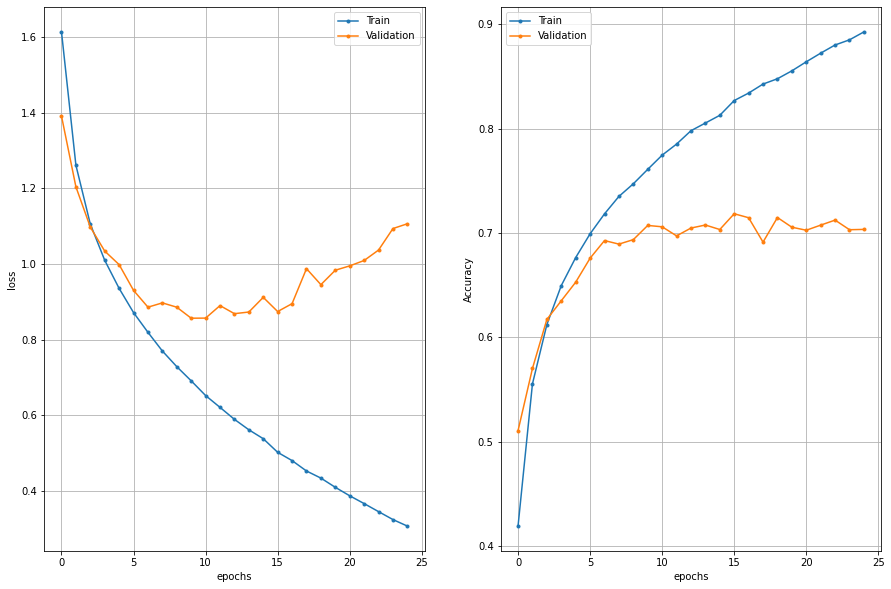

In [17]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1]) 

* Make **one** modification (that you think can help) and train the classifier again. Does the accuracy improve?

It is improved from 69% to 71%

Train Acc      0.8911749720573425
Validation Acc 0.7150999903678894

Let's add horizontal flipping and see if this can help

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

gen = ImageDataGenerator(horizontal_flip=True)

batches = gen.flow(x_train, y_train, batch_size=64)
val_batches = gen.flow(x_test, y_test, batch_size=64)

epochs = 25
batch_size = 128

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


gen.fit(x_train)
    
#history3 = model.fit_generator(batches,  epochs=25,
#                    validation_data=val_batches,  callbacks=[early_stopping], use_multiprocessing=True)

history3 = model.fit_generator(batches,  epochs=20,
                    validation_data=val_batches, use_multiprocessing=True)

#plot_history(history)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
625/625 [==============================] - 6s 10ms/step - loss: 0.6948 - accuracy: 0.7763 - val_loss: 0.8668 - val_accuracy: 0.7148
Epoch 2/20
625/625 [==============================] - 7s 11ms/step - loss: 0.5928 - accuracy: 0.8012 - val_loss: 0.8823 - val_accuracy: 0.7091
Epoch 3/20
625/625 [==============================] - 6s 9ms/step - loss: 0.5713 - accuracy: 0.8038 - val_loss: 0.8616 - val_accuracy: 0.7232
Epoch 4/20
625/625 [==============================] - 6s 10ms/step - loss: 0.5684 - accuracy: 0.8064 - val_loss: 0.8836 - val_accuracy: 0.7161
Epoch 5/20
625/625 [==============================] - 6s 10ms/step - loss: 0.5370 - accuracy: 0.8172 - val_loss: 0.8420 - val_accuracy: 0.7329
Epoch 6/20
625/625 [==============================] - 6s 10ms/step - loss: 0.5224 - accuracy: 0.8175 - val_loss: 0.8406 - val_accuracy: 0.7287
Epoch 7/20
625/625 [==============================] - 7s 11ms/step - loss: 0.5164 - accuracy: 0.8220 - val_loss: 0.8546 - val_accuracy: 0.7253


Train Acc      0.8927000164985657
Validation Acc 0.7034000158309937


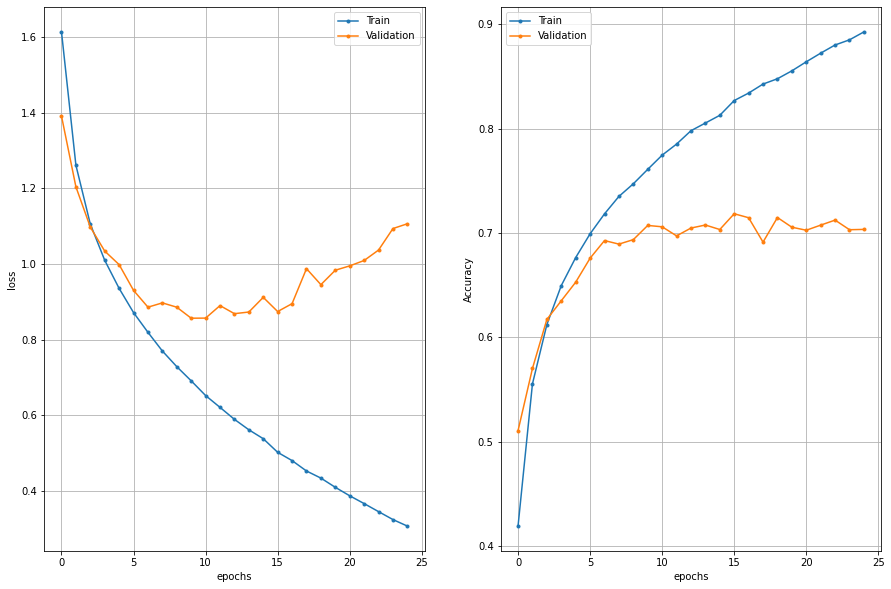

In [19]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])    

Result: Accuracy slightly improved. Looks like we need more sophisticated model, I believe this will be a part of the next homework.